# Task 2 - Predictive modeling of customer bookings

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import os

# For visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data-Prep
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Model Buidling and metrics 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from sklearn.model_selection import cross_val_score


# 1.Loading the dataset

In [2]:
data = pd.read_csv("data/customer_booking.csv")
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

# 2.Data-preprocessing

## 2.1.Checking for null values

In [4]:
data.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [5]:
data.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


### No null values in our dataset

## 2.2.Feature Encoding

In [6]:
# Separating categorical and numerical columns
data_categorical = data.select_dtypes(include="object")
data_numerical = data.select_dtypes(exclude="object")

In [7]:
data_categorical.head()

,sales_channel,trip_type,flight_day,route,booking_origin
0,Internet,RoundTrip,Sat,AKLDEL,New Zealand
1,Internet,RoundTrip,Sat,AKLDEL,New Zealand
2,Internet,RoundTrip,Wed,AKLDEL,India
3,Internet,RoundTrip,Sat,AKLDEL,New Zealand
4,Internet,RoundTrip,Wed,AKLDEL,India


In [8]:
for col in data_categorical:
    print(data_categorical[col].value_counts())
    print("\n")

Internet    44382
Mobile       5618
Name: sales_channel, dtype: int64


RoundTrip     49497
OneWay          387
CircleTrip      116
Name: trip_type, dtype: int64


Mon    8102
Wed    7674
Tue    7673
Thu    7424
Fri    6761
Sun    6554
Sat    5812
Name: flight_day, dtype: int64


AKLKUL    2680
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
BTUWUH       1
MELVTE       1
KBRWUH       1
DACMRU       1
BKIMRU       1
Name: route, Length: 799, dtype: int64


Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
               ...  
Guatemala          1
Bhutan             1
Belarus            1
Bulgaria           1
Paraguay           1
Name: booking_origin, Length: 104, dtype: int64




### Using OneHotEncdoing 

In [9]:
data_categorical.columns

Index(['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin'], dtype='object')

In [10]:
columns = ['sales_channel', 'trip_type', 'flight_day', 'route', 'booking_origin']
for value in columns:
    data_categorical=pd.get_dummies(data_categorical, columns=[value],drop_first=True)

In [11]:
data_categorical.shape

(50000, 910)

In [12]:
data_categorical.head()

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,route_AKLHGH,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## 2.3.Outlier detection

In [13]:
data_numerical.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,262,19,7,1,0,0,5.52,0
1,1,112,20,3,0,0,0,5.52,0
2,2,243,22,17,1,1,0,5.52,0
3,1,96,31,4,0,0,1,5.52,0
4,2,68,22,15,1,0,1,5.52,0


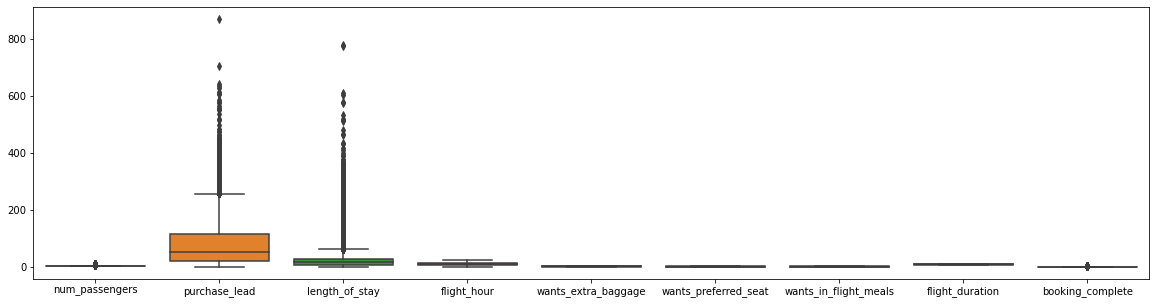

In [14]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(20,5))
sns.boxplot(data = data_numerical)
plt.show()

In [15]:
data_numerical.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration', 'booking_complete'],
      dtype='object')

In [16]:
# Replacing outliers with median
#function to return a list of index of outliers
column_list = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration']
for feature in column_list:
    Q1= data_numerical[feature].quantile(0.25)
    Q3 =data_numerical[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    
    lower_limit = Q1 - 1.5 * IQR
    
    upper_limit = Q3 + 1.5 * IQR
  
    
    median = data_numerical[feature].median()
    
    data_numerical[feature] = np.where(data_numerical[feature]< lower_limit, median,data_numerical[feature])
    data_numerical[feature] = np.where(data_numerical[feature]> upper_limit, median,data_numerical[feature])

<ipython-input-16-9a3a3442808e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_numerical[feature] = np.where(data_numerical[feature]< lower_limit, median,data_numerical[feature])
<ipython-input-16-9a3a3442808e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_numerical[feature] = np.where(data_numerical[feature]> upper_limit, median,data_numerical[feature])
<ipython-input-16-9a3a3442808e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

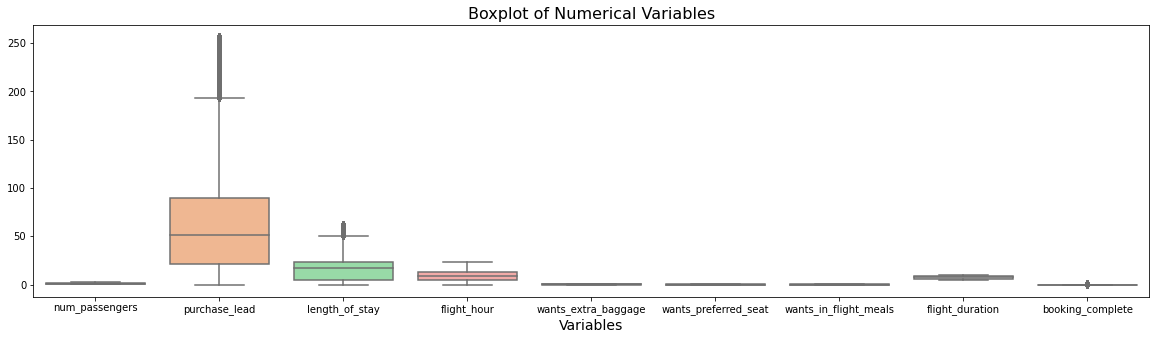

In [22]:
# Plotting boxplot for detecting outliers
plt.figure(figsize=(20,5))
sns.boxplot(data=data_numerical, palette='pastel')
plt.title('Boxplot of Numerical Variables', fontsize=16)
plt.xlabel('Variables', fontsize=14)
plt.show()


## 2.4.Feature Scaling

In [23]:
# combining numerical and categorical column data
df = pd.concat([data_categorical,data_numerical], axis =1)

In [24]:
df.head()

,sales_channel_Mobile,trip_type_OneWay,trip_type_RoundTrip,flight_day_Mon,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,route_AKLHGH,...,booking_origin_Vietnam,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,0,1,0,1,0,0,0,0,0,...,0,2.0,51.0,19.0,7.0,1.0,0.0,0.0,5.52,0
1,0,0,1,0,1,0,0,0,0,0,...,0,1.0,112.0,20.0,3.0,0.0,0.0,0.0,5.52,0
2,0,0,1,0,0,0,0,0,1,0,...,0,2.0,243.0,22.0,17.0,1.0,1.0,0.0,5.52,0
3,0,0,1,0,1,0,0,0,0,0,...,0,1.0,96.0,31.0,4.0,0.0,0.0,1.0,5.52,0
4,0,0,1,0,0,0,0,0,1,0,...,0,2.0,68.0,22.0,15.0,1.0,0.0,1.0,5.52,0


In [25]:
# Separating dependent and independent variables
X = df.drop(["booking_complete"] , axis=1)
y = df["booking_complete"]

In [26]:
# Using StandardScaler 
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [27]:
X_scaled = pd.DataFrame(X_scaled)

In [28]:
X_scaled

,0,1,2,3,4,5,6,7,8,9,...,908,909,910,911,912,913,914,915,916,917
0,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,1.056055,-0.246182,0.231165,-0.381764,0.703747,-0.649919,-0.863497,-1.174175
1,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,0.767907,0.305232,-1.120780,-1.420965,-0.649919,-0.863497,-1.174175
2,-0.355785,-0.08832,0.100808,-0.439744,-0.362669,-0.388399,-0.417577,-0.425769,2.348512,-0.004472,...,-0.004472,-0.088435,1.056055,2.945705,0.453365,1.465775,0.703747,1.538654,-0.863497,-1.174175
3,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,0.501916,1.119966,-0.936026,-1.420965,-0.649919,1.158082,-1.174175
4,-0.355785,-0.08832,0.100808,-0.439744,-0.362669,-0.388399,-0.417577,-0.425769,2.348512,-0.004472,...,-0.004472,-0.088435,1.056055,0.036433,0.453365,1.096267,0.703747,-0.649919,1.158082,-1.174175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,1.056055,-0.645168,-0.731702,-0.012257,0.703747,-0.649919,1.158082,-1.107368
49996,-0.355785,-0.08832,0.100808,-0.439744,-0.362669,2.574671,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,0.751282,-0.731702,-0.936026,-1.420965,-0.649919,-0.863497,-1.107368
49997,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,-0.695041,-0.731702,2.389544,-1.420965,-0.649919,1.158082,-1.107368
49998,-0.355785,-0.08832,0.100808,2.274053,-0.362669,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,-0.844661,-0.731702,0.357251,0.703747,-0.649919,1.158082,-1.107368


In [29]:
y

0        0
1        0
2        0
3        0
4        0
        ..
49995    0
49996    0
49997    0
49998    0
49999    0
Name: booking_complete, Length: 50000, dtype: int64

## 2.5.Checking Data is imbalanced or not

In [30]:
y.value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

### Our dataset is imbalanced. 
#### Class Imbalance is a quite common problem and if not handled can have a impact on the model performance. 
#### To create a balanced datase we will use SMOTE

In [31]:
print(X.shape)
print(y.shape)

(50000, 918)
(50000,)


In [32]:
# using imblearn to removing imablance in our dataset
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(X_scaled, y)
print(x_smote.shape)
print(y_smote.shape)

(85044, 918)
(85044,)


In [33]:
x_smote.head()

,0,1,2,3,4,5,6,7,8,9,...,908,909,910,911,912,913,914,915,916,917
0,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,1.056055,-0.246182,0.231165,-0.381764,0.703747,-0.649919,-0.863497,-1.174175
1,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,0.767907,0.305232,-1.120780,-1.420965,-0.649919,-0.863497,-1.174175
2,-0.355785,-0.08832,0.100808,-0.439744,-0.362669,-0.388399,-0.417577,-0.425769,2.348512,-0.004472,...,-0.004472,-0.088435,1.056055,2.945705,0.453365,1.465775,0.703747,1.538654,-0.863497,-1.174175
3,-0.355785,-0.08832,0.100808,-0.439744,2.757334,-0.388399,-0.417577,-0.425769,-0.425802,-0.004472,...,-0.004472,-0.088435,-0.630179,0.501916,1.119966,-0.936026,-1.420965,-0.649919,1.158082,-1.174175
4,-0.355785,-0.08832,0.100808,-0.439744,-0.362669,-0.388399,-0.417577,-0.425769,2.348512,-0.004472,...,-0.004472,-0.088435,1.056055,0.036433,0.453365,1.096267,0.703747,-0.649919,1.158082,-1.174175


In [34]:
y_smote.head()

0    0
1    0
2    0
3    0
4    0
Name: booking_complete, dtype: int64

### This is all about preprocessing steps for the dataset

# 3.EDA

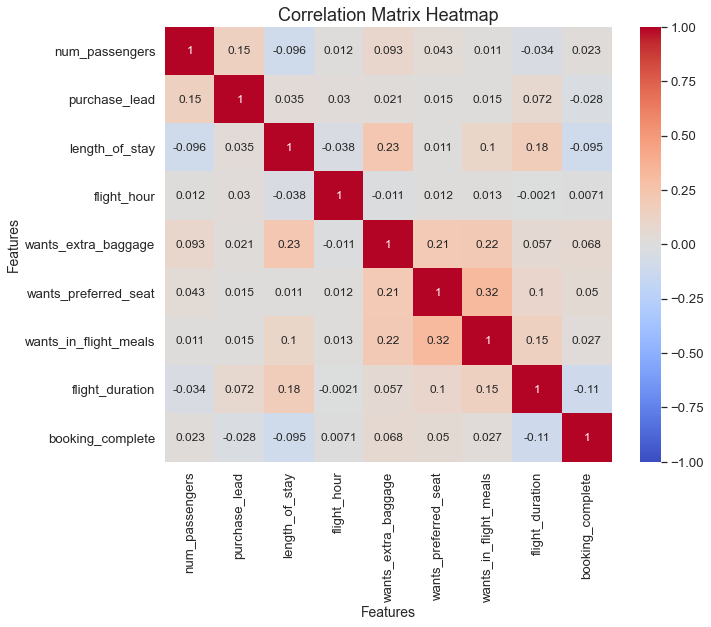

In [36]:
# Set font size and style
sns.set(font_scale=1.2, style="whitegrid")

# Create heatmap with correlation matrix
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(data_numerical.corr(),
                      cmap="coolwarm",
                      annot=True,
                      annot_kws={"size": 12},
                      vmin=-1, vmax=1)

# Set heatmap title and axis labels
heatmap.set_title("Correlation Matrix Heatmap", fontdict={"fontsize": 18})
heatmap.set_xlabel("Features", fontdict={"fontsize": 14})
heatmap.set_ylabel("Features", fontdict={"fontsize": 14})

plt.show()

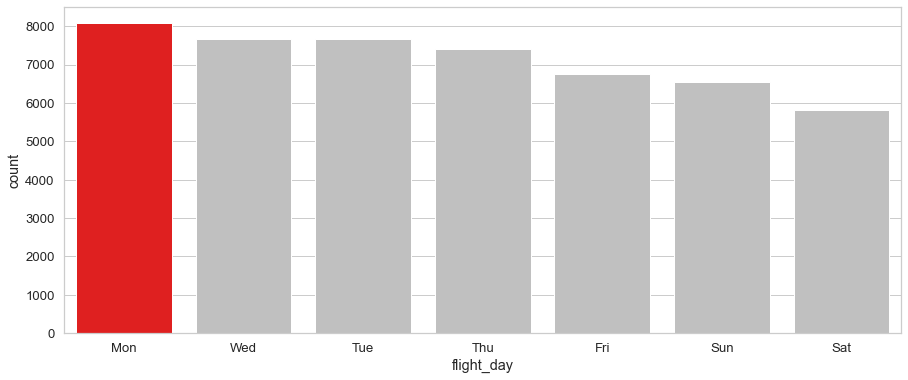

In [40]:
import seaborn as sns

# Hitung jumlah penerbangan pada setiap hari
flight_day_counts = data["flight_day"].value_counts()

# Tentukan warna untuk setiap bar
colors = ["silver" if count != flight_day_counts.max() else "red" for count in flight_day_counts]

# Plot bar dengan warna yang ditentukan
plt.figure(figsize=(15,6))
sns.countplot(x="flight_day", data=data, order=flight_day_counts.index, palette=colors)
plt.show()

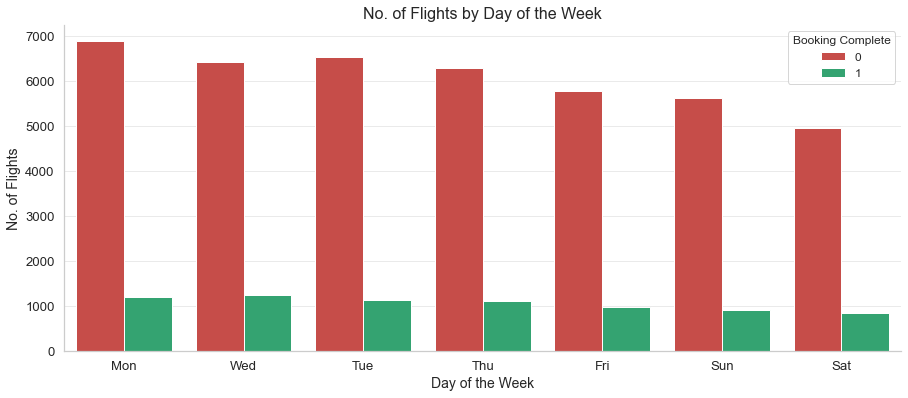

In [42]:
# Setting color palette
colors = ['#DB3A34', '#22B573']

# No. of flights on each day of the week
plt.figure(figsize=(15,6))
sns.countplot(x="flight_day", hue="booking_complete", data=data, order=data["flight_day"].value_counts().index, palette=colors)

# Setting title and axis labels
plt.title("No. of Flights by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=14)
plt.ylabel("No. of Flights", fontsize=14)

# Setting legend
plt.legend(title="Booking Complete", fontsize=12, title_fontsize=12)

# Removing spines
sns.despine()

# Adding gridlines
plt.grid(True, axis='y', alpha=0.4)

# Show plot
plt.show()


### No of flights is max on monday and lowest on Saturday

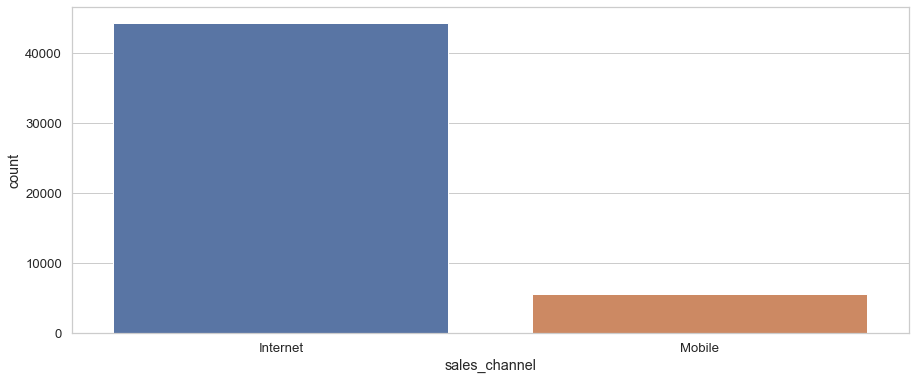

In [49]:
# Frequently used Booking channel
plt.figure(figsize=(15,6))
sns.countplot(x = "sales_channel", data=data, order=data["sales_channel"].value_counts().index)
plt.show()

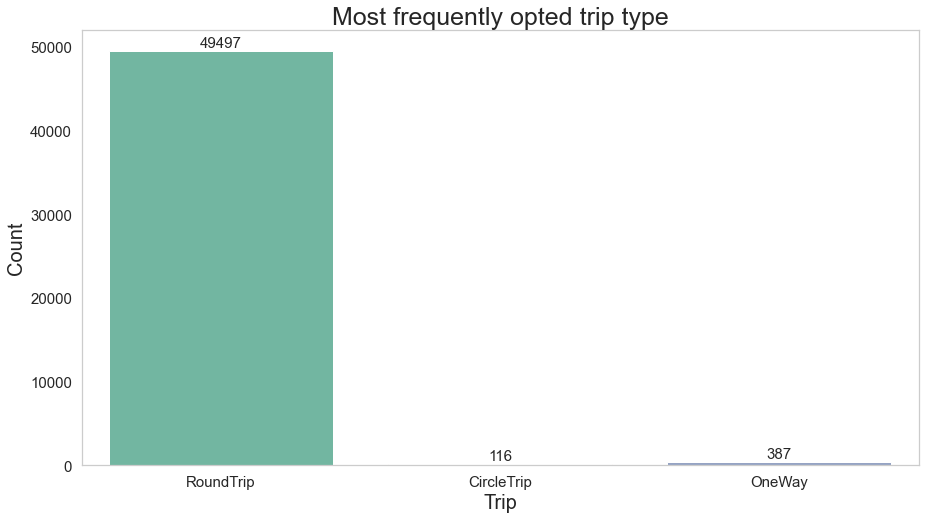

In [50]:
# Most frequently opted trip type
plt.figure(figsize=(15,8))
plots = sns.countplot(x="trip_type",  data=data, palette="Set2")
plt.xlabel("Trip",fontsize= 20)
plt.ylabel("Count", fontsize= 20)
plt.title("Most frequently opted trip type", fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(axis="y", linestyle='--')

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')   

plt.show()


# Most passengers prefer to book round trip

In [51]:
data["booking_origin"].value_counts(ascending=False)

Australia      17872
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
               ...  
Guatemala          1
Bhutan             1
Belarus            1
Bulgaria           1
Paraguay           1
Name: booking_origin, Length: 104, dtype: int64

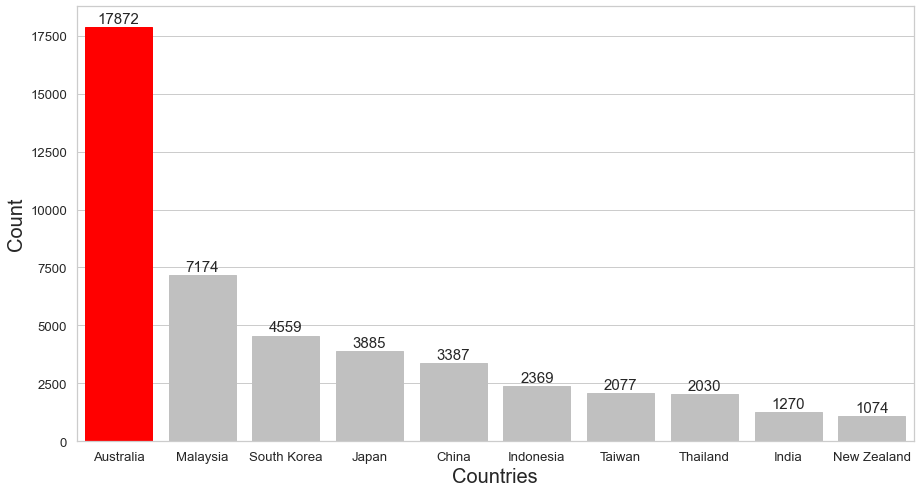

In [55]:
# Top 10 Countries in flight bookings
plt.figure(figsize=(15,8))
plots = sns.countplot(x="booking_origin",  data=data ,order=data.booking_origin.value_counts().iloc[:10].index)
plt.xlabel("Countries",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

max_val = max([bar.get_height() for bar in plots.containers[0]])

for bar in plots.patches:
    if bar.get_height() == max_val:
        bar.set_color('red')
    else:
        bar.set_color('silver')

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')


### Top 10 Countries with flight bookings

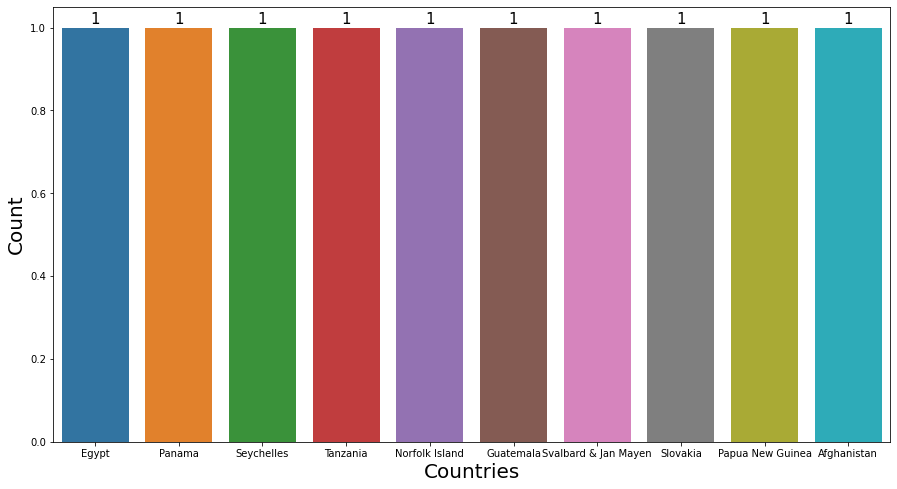

In [39]:
# Bottom 10 Countries in flight bookings
plt.figure(figsize=(15,8))
plots = sns.countplot(x="booking_origin",  data=data ,order=data.booking_origin.value_counts().iloc[-10:].index)
plt.xlabel("Countries",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=15, xytext=(0, 8),textcoords='offset points')   

### Bottom 10 Countries with flight bookings

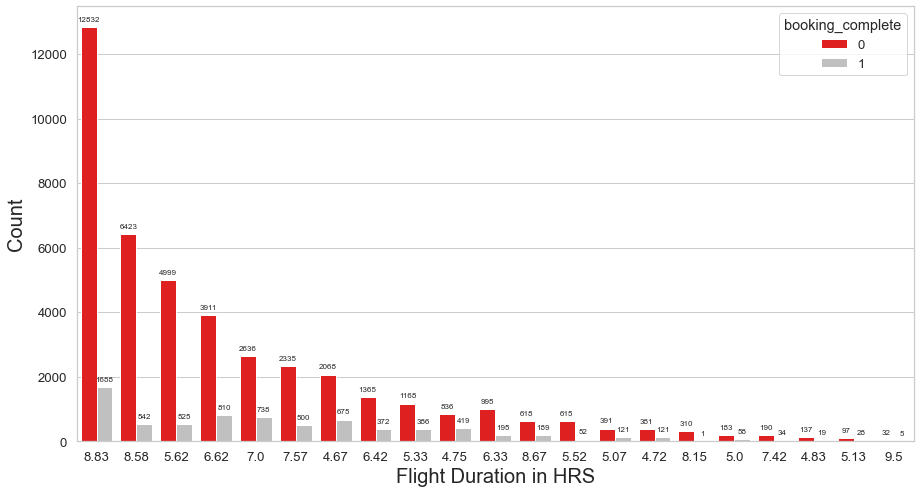

In [56]:
plt.figure(figsize=(15,8))
palette = ["red"] + ["silver"]*(len(data.flight_duration.value_counts().index)-1)
plots = sns.countplot(x="flight_duration", hue="booking_complete" , data=data ,order=data.flight_duration.value_counts().index, palette=palette)
plt.xlabel("Flight Duration in HRS",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=8, xytext=(0, 8),textcoords='offset points')


### Majority of the Passengers are not opting for British airways flights which has flights duration >=8.

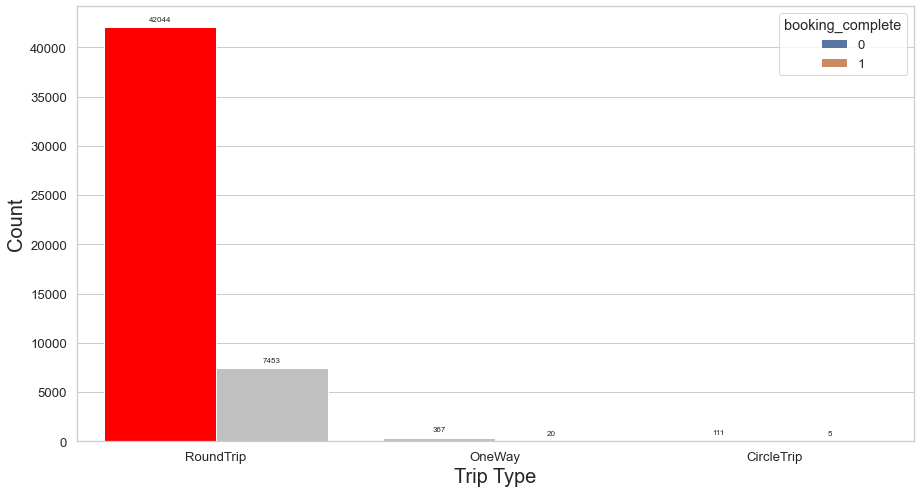

In [57]:
plt.figure(figsize=(15,8))
plots = sns.countplot(x="trip_type", hue="booking_complete", data=data, order=data.trip_type.value_counts().index)
plt.xlabel("Trip Type", fontsize=20)
plt.ylabel("Count", fontsize=20)

# Mendapatkan nilai tertinggi dari masing-masing bar plot
top_values = [p.get_height() for p in plots.patches]
max_value = max(top_values)

# Memberikan warna merah pada bar plot dengan nilai tertinggi dan silver pada yang lainnya
for p in plots.patches:
    if p.get_height() == max_value:
        p.set_fc('red')
    else:
        p.set_fc('silver')
        
# Menampilkan anotasi pada bar plot
for p in plots.patches:
    plots.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha='center', va='center', size=8, xytext=(0, 8), textcoords='offset points')


### Most of the enquires are from passengers who are looking for round trip.

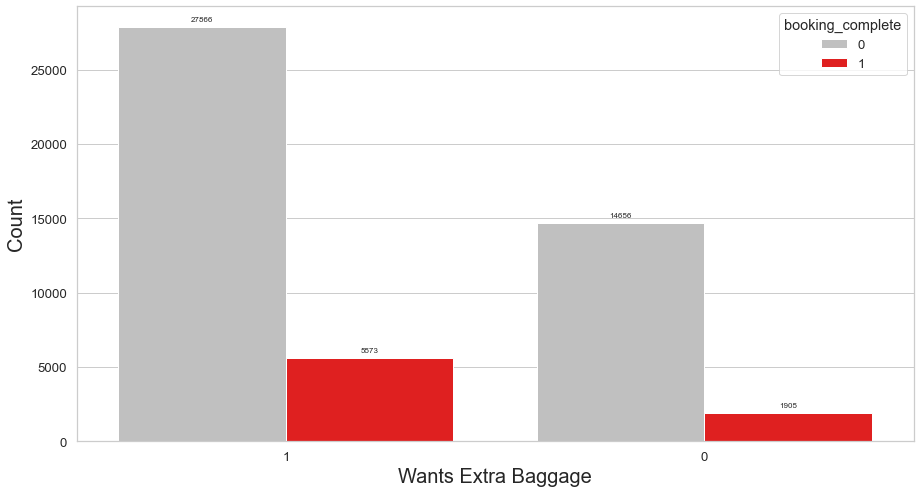

In [62]:
# trip type and booking complete
plt.figure(figsize=(15,8))
plots = sns.countplot(x="wants_extra_baggage", hue="booking_complete", data=data, order=data.wants_extra_baggage.value_counts().index, palette={True: "red", False: "silver"})
plt.xlabel("Wants Extra Baggage",fontsize= 20)
plt.ylabel("Count", fontsize= 20)

for bar in plots.patches:
    plots.annotate(format(bar.get_height()),(bar.get_x() + bar.get_width() / 2,bar.get_height()), 
                   ha='center', va='center',size=8, xytext=(0, 8),textcoords='offset points')


# 4.Splitting the dataset into train and test

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_smote,y_smote, test_size=0.25,random_state=101)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(63783, 918)
(21261, 918)
(63783,)
(21261,)


# 5.Building model

In [63]:
# using random forest classifier
rforest = RandomForestClassifier()
rforest.fit(x_train, y_train)

RandomForestClassifier()

# 6.Predicting the test data

In [64]:
y_pred_rf_train = rforest.predict(x_train)
y_pred_rf_test = rforest.predict(x_test)

# 7.Performance metrics

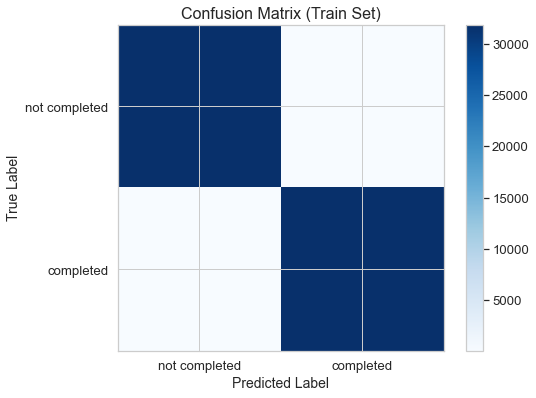

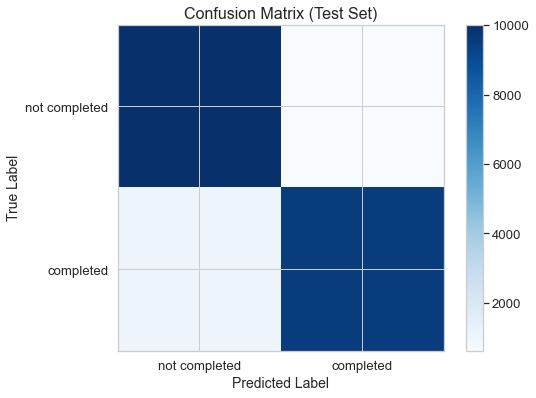

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# hitung confusion matrix
cm_train = confusion_matrix(y_train, y_pred_rf_train)
cm_test = confusion_matrix(y_test, y_pred_rf_test)

# plot confusion matrix train
plt.figure(figsize=(8, 6))
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix (Train Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks([0, 1], ['not completed', 'completed'])
plt.yticks([0, 1], ['not completed', 'completed'])
plt.show()

# plot confusion matrix test
plt.figure(figsize=(8, 6))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix (Test Set)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks([0, 1], ['not completed', 'completed'])
plt.yticks([0, 1], ['not completed', 'completed'])
plt.show()


In [82]:
print(classification_report(y_train, y_pred_rf_train))
print("####"*30)
print(classification_report(y_test, y_pred_rf_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31892
           1       1.00      1.00      1.00     31891

    accuracy                           1.00     63783
   macro avg       1.00      1.00      1.00     63783
weighted avg       1.00      1.00      1.00     63783

########################################################################################################################
              precision    recall  f1-score   support

           0       0.90      0.94      0.92     10630
           1       0.94      0.90      0.92     10631

    accuracy                           0.92     21261
   macro avg       0.92      0.92      0.92     21261
weighted avg       0.92      0.92      0.92     21261



In [84]:
from sklearn.metrics import accuracy_score

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_rf_train)
test_accuracy = accuracy_score(y_test, y_pred_rf_test)

# Display results
print("Train Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))


Train Accuracy: 99.99%
Test Accuracy: 92.07%


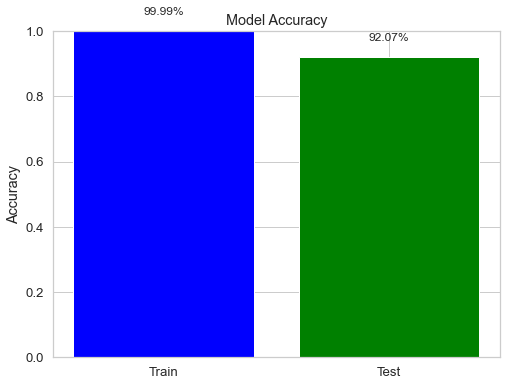

In [85]:
import matplotlib.pyplot as plt

# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_pred_rf_train)
test_accuracy = accuracy_score(y_test, y_pred_rf_test)

# Plot bar chart
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(["Train", "Test"], [train_accuracy, test_accuracy], color=["blue", "green"])
ax.set_ylim([0,1])
ax.set_ylabel("Accuracy")
ax.set_title("Model Accuracy")

# Annotate bars with values
for i, v in enumerate([train_accuracy, test_accuracy]):
    ax.text(i, v+0.05, "{:.2f}%".format(v*100), ha='center', fontsize=12)

plt.show()


# 8.Cross Validation

In [86]:
# Using K-FOLD method by using cross_val_score
accuracy = cross_val_score(rforest, x_train, y_train, cv=10)

In [87]:
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(accuracy.mean()*100, accuracy.std()*100))

Accuracy: 91.80% (+/- 0.25%)


In [88]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Create random forest model
rforest = RandomForestClassifier()

# Compute cross-validation accuracy scores
accuracy = cross_val_score(rforest, x_train, y_train, cv=10)

# Print mean and standard deviation of accuracy scores
print("Accuracy: {:.2f}% (+/- {:.2f}%)".format(accuracy.mean()*100, accuracy.std()*100))


Accuracy: 91.80% (+/- 0.31%)
